In [ ]:
Running omega 

https://cme.h-its.org/exelixis/web/software/omegaplus/index.html

In [2]:
import allel
import numpy as np
import pandas as pd
import subprocess
import datetime


python(79223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
## because omega can run directly on the vcf files, i will unzip the gzipped files
for i in {1..5}; do
  bcftools view -r $i modern_imputed.vcf.gz -Oz -o modern_chr${i}.vcf.gz
done


for file in *.vcf.gz; do
    gunzip -k "$file"

In [1]:
import datetime

# Constants
sbatch_path = "/carnegie/nobackup/scratch/tbellagio/selection_scan/omega"
omega_exec = "./omegaplus/OmegaPlus-G"  # change to your actual OmegaPlus binary path
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

batch_script_list = []

for chr_num in range(1, 6):
    sbatch_filename = f"sbatch_omegaplus_chr{chr_num}.sh"
    log_filename = f"{sbatch_path}/omega_chr{chr_num}_{timestamp}_output.txt"
    vcf_path = f"modern_chr{chr_num}.vcf"  # assumes these files already exist

    sbatch_script = f"""#!/bin/bash
#SBATCH --job-name="omega_chr{chr_num}"
#SBATCH --time=4:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=2
#SBATCH --mem=8G
#SBATCH --output={log_filename}
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd {sbatch_path}
source /home/tbellagio/miniforge3/etc/profile.d/conda.sh
conda activate /home/tbellagio/miniforge3/envs/gwas
cd /carnegie/nobackup/scratch/tbellagio/selection_scan/omega
pwd
echo "Running OmegaPlus on chromosome {chr_num}..."

{omega_exec} \\
  -name omega_chr{chr_num} \\
  -input {vcf_path} \\
  -ld RSQUARE \\
  -grid 10000 \\
  -minwin 1000 \\
  -maxwin 100000 \\
  -memLimit 8000 \\
  -threads 2 \\
  -seed 42

echo "Done with chromosome {chr_num}"
"""

    with open(sbatch_filename, 'w') as f:
        f.write(sbatch_script)

    batch_script_list.append(sbatch_filename)


In [ ]:
for i in range(len(batch_script_list)):
    subprocess.run(['sbatch', batch_script_list[i]])

In [64]:
## read results 
import pandas as pd
import glob

chrom_lengths = {}  # Will store chromosome lengths for cumulative position

# Assume these are your chromosomes
chroms = ['1', '2', '3', '4', '5']
omega_files = [f'OmegaPlus_Report.omega_chr{c}' for c in chroms]

omega_all = []
offset = 0

for c, file in zip(chroms, omega_files):
    df = pd.read_csv(file, sep='\t', header=None, names=['position', 'omega'], skiprows =2)
    df['chrom'] = c
    df['pos_cum'] = df['position'] + offset
    omega_all.append(df)
    
    chrom_lengths[c] = df['position'].max()
    offset += df['position'].max()

# Combine all chromosomes
omega_df_all = pd.concat(omega_all, ignore_index=True)

In [11]:
#omega_df_all.to_csv('omega_grid1000.csv', index=None)

In [12]:
omega_df_all = pd.read_csv('omega_grid1000.csv')

In [3]:
genes_df = pd.read_csv('../genes_df.csv')

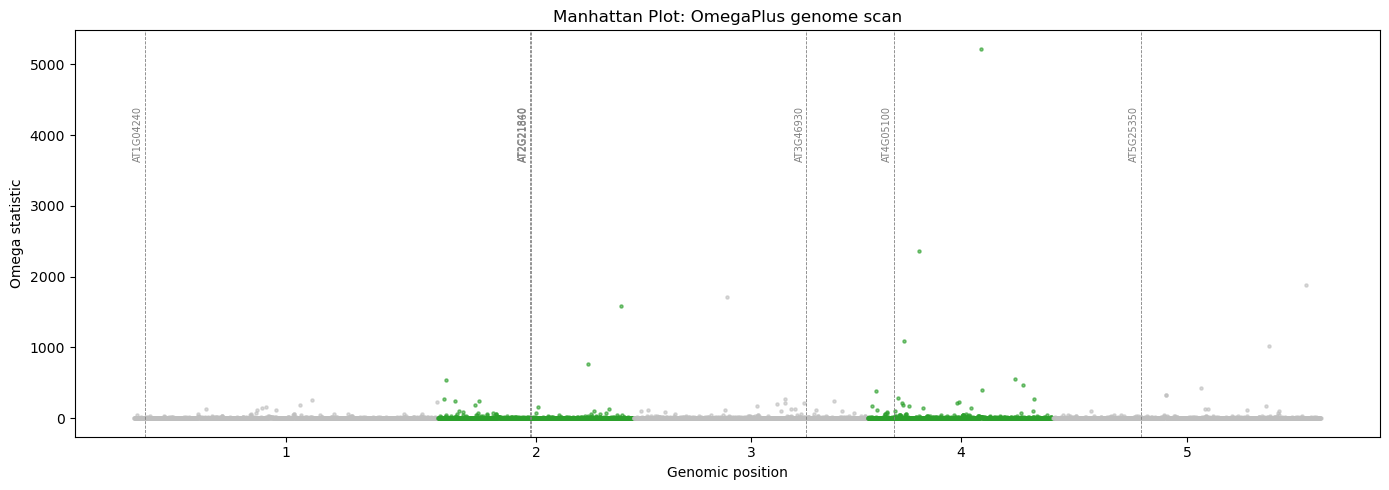

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

# Plot Omega statistic
for i, (chrom, group) in enumerate(omega_df_all.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['omega'], s=5, alpha=0.6,
                color=colors[i % 2], label=f'Chr {chrom}')
plt.legend().remove()

# Add chromosome ticks
xticks = omega_df_all.groupby('chrom')['pos_cum'].median()
xtick_labels = omega_df_all.groupby('chrom')['chrom'].first()
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.xlabel('Genomic position')
plt.ylabel('Omega statistic')
plt.title('Manhattan Plot: OmegaPlus genome scan')
plt.tight_layout()

# Annotate genes of interest
for _, row in genes_df.iterrows():
    chrom = row['chrom']  # Ensure chrom is same type as in omega_df_all
    gene_center = (row['start'] + row['end']) // 2
    subset = omega_df_all[omega_df_all['chrom'] == chrom]

    if not subset.empty:
        nearest_idx = (subset['position'] - gene_center).abs().idxmin()
        gene_pos_cum = subset.loc[nearest_idx, 'pos_cum']
        gene_id = row['gene_id']

        # Plot vertical line and label
        plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)
        plt.text(gene_pos_cum - 7e5, omega_df_all['omega'].max() * 0.7, gene_id,
                 rotation=90, fontsize=7, color='grey', ha='center')

plt.show()



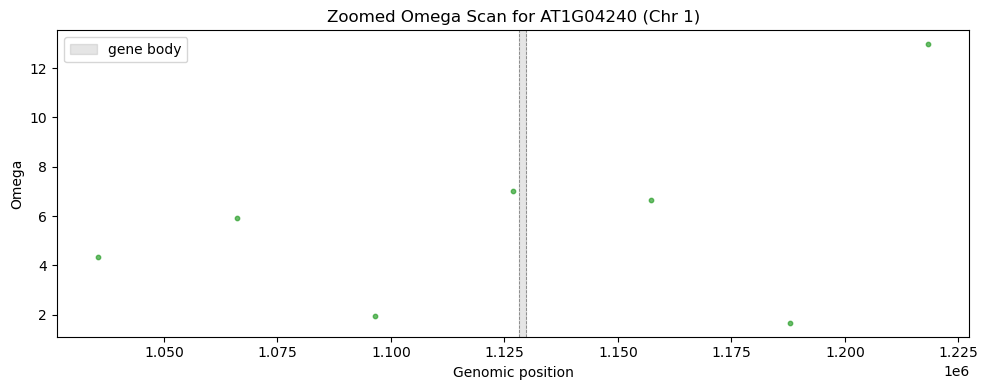

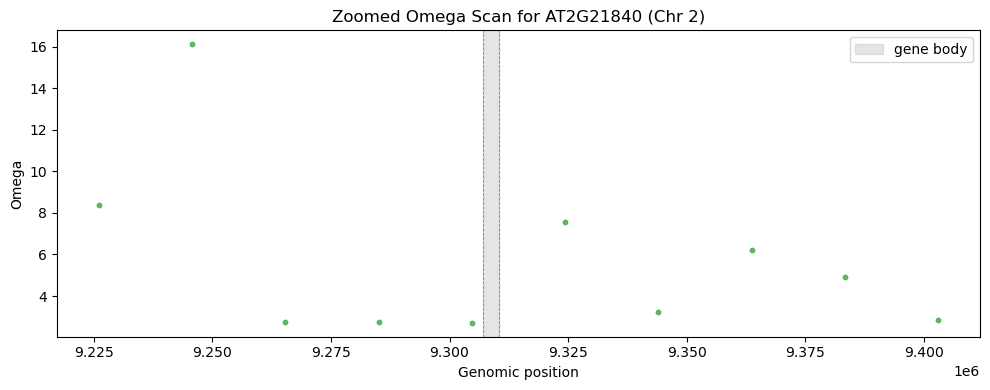

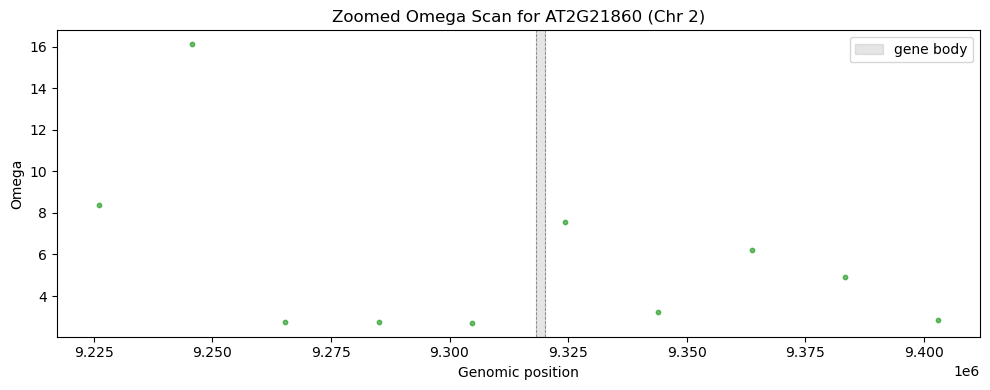

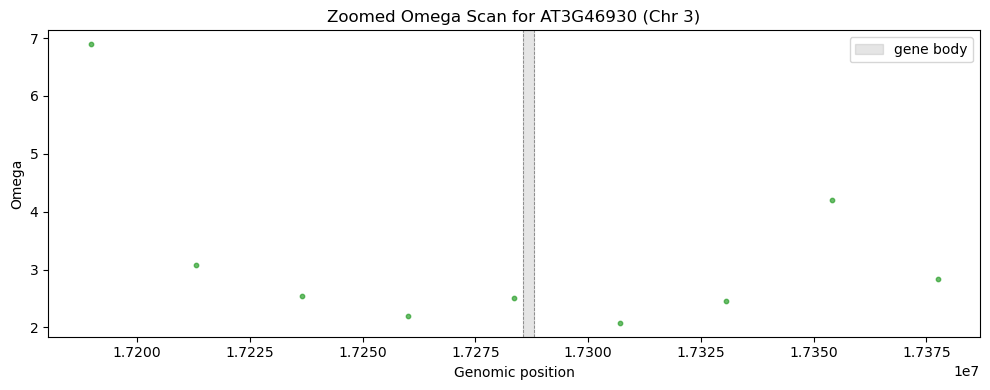

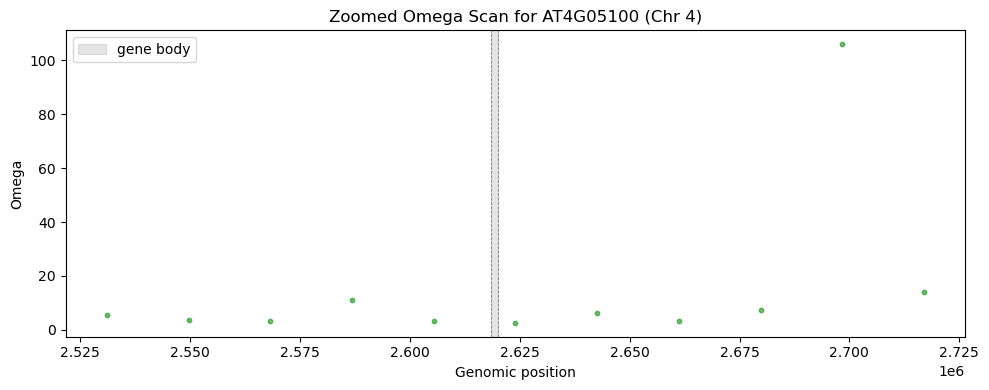

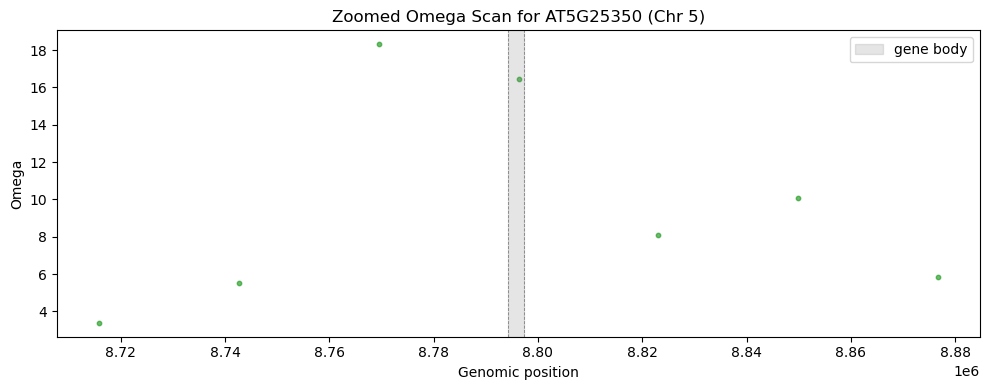

In [9]:
import matplotlib.pyplot as plt

for _, row in genes_df.iterrows():
    chrom = row['chrom']  # match type in omega_df_all
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']

    # Subset data for ±100 kb around the gene
    region_df = omega_df_all[
        (omega_df_all['chrom'] == chrom) &
        (omega_df_all['position'] >= gene_start - 100_000) &
        (omega_df_all['position'] <= gene_end + 100_000)
    ]

    if region_df.empty:
        continue  # Skip genes with no data in region

    # Plot
    plt.figure(figsize=(10, 4))
    plt.scatter(region_df['position'], region_df['omega'], s=10, alpha=0.7, color='#2ca02c')

    # Highlight gene
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    plt.title(f'Zoomed Omega Scan for {gene_id} (Chr {chrom})')
    plt.xlabel('Genomic position')
    plt.ylabel('Omega')
    plt.legend()
    plt.tight_layout()
    plt.show()
